<a href="https://colab.research.google.com/github/santiagofloresm/ENEL645-Team25-FinalProject/blob/santiago-xception/FinalProject-Phase2_Import.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project
## Team 25
Santiago Flores - 30119885

Davis Allan - 10016543

Jordan Joorisity - 30117950

Patrick Pickard - 30116807

Joshua Posyluzny - 30118206

# 1. Loading and pre-processing the dataset

### 1.1 Clone the repository

In [1]:
!git clone -b dev https://github.com/santiagofloresm/ENEL645-Team25-FinalProject.git

Cloning into 'ENEL645-Team25-FinalProject'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 156904 (delta 22), reused 12 (delta 4), pack-reused 156860
Receiving objects: 100% (156904/156904), 2.86 GiB | 44.45 MiB/s, done.
Resolving deltas: 100% (213/213), done.
Checking out files: 100% (168575/168575), done.


### 1.2 Define the paths original dataset

In [2]:
train_folder = 'ENEL645-Team25-FinalProject/Dataset/Train'
test_folder = 'ENEL645-Team25-FinalProject/Dataset/Alternative_Test'
validation_folder = 'ENEL645-Team25-FinalProject/Dataset/Validation'

### 1.3 Data display

There are 29 classes in the dataset, one for each letter in the English alphabet, one for space, one for delete and a blank one. Below is an exmaple of each one

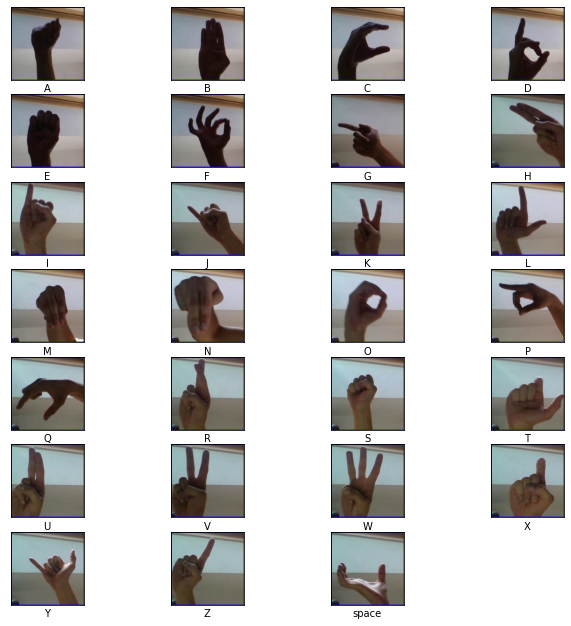

In [3]:
import matplotlib.pyplot as plt

classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 
           'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 
           'W', 'X', 'Y', 'Z', 'space']

plt.figure(figsize=(11,11))
for i in range (0,27):
  plt.subplot(7,4, i+1)
  plt.xticks([])
  plt.yticks([])
  path = train_folder + "/" + classes[i] + "/" + classes[i] + "2.jpg"
  img = plt.imread(path)
  plt.imshow(img)
  plt.xlabel(classes[i])

### 1.5 Data import and augmentation

In [4]:
from keras.preprocessing.image import ImageDataGenerator

image_input_dimensions_3d = (200,200,3)
image_input_dimensions_2d = (200,200)
batch_size = 50
seed = 32

#### 1.5.1 Training data

In [5]:
# https://keras.io/api/preprocessing/image/
# categorical class_mode will be 2D one-hot encoded labels
# The dictionary containing the mapping from class names to class indices can be obtained via the attribute class_indices
train_data_gen = ImageDataGenerator(brightness_range=[0.5, 1.5], 
                                    rotation_range=10,
                                    horizontal_flip=True, 
                                    rescale=1./255)

train_generator = train_data_gen.flow_from_directory(train_folder, 
                                                     batch_size=batch_size, 
                                                     seed=seed,  
                                                     target_size=image_input_dimensions_2d,                                    
                                                     class_mode="categorical",
                                                     subset="training")

Found 69600 images belonging to 29 classes.


In [6]:
val_data_gen = ImageDataGenerator(rescale=1./255)

val_generator = val_data_gen.flow_from_directory(validation_folder, 
                                                 batch_size=batch_size, 
                                                 seed=seed,
                                                 target_size=image_input_dimensions_2d,  
                                                 class_mode="categorical")

Found 8700 images belonging to 29 classes.


In [7]:
test_data_gen = ImageDataGenerator(rescale=1./255)

test_generator = test_data_gen.flow_from_directory(test_folder, 
                                                   batch_size=batch_size, 
                                                   seed=seed,
                                                   target_size=image_input_dimensions_2d,  
                                                   class_mode="categorical")

Found 870 images belonging to 29 classes.


In [8]:
import tensorflow as tf

model_name = "xception_model.h5"
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 5)

monitor = tf.keras.callbacks.ModelCheckpoint(model_name, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=True,\
                                             mode='min')
# Learning rate schedule
def scheduler(epoch, lr):
    if epoch%4 == 0 and epoch!= 0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

In [9]:
base_model = tf.keras.applications.Xception(
    weights='imagenet',
    input_shape=image_input_dimensions_3d,
    include_top=False)
base_model.trainable = False

83689472/83683744 [==============================] - 1s 0us/step


In [10]:
input_image = tf.keras.Input(shape=image_input_dimensions_3d)
x1 = base_model(input_image, training=False)
x2 = tf.keras.layers.Flatten()(x1)
out = tf.keras.layers.Dense(29,activation = 'softmax')(x2)
model = tf.keras.Model(inputs = input_image, outputs =out)
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 29)                2910237   
Total params: 23,771,717
Trainable params: 2,910,237
Non-trainable params: 20,861,480
_________________________________________________________________
None


In [11]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-4, clipvalue=0.1),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_generator, epochs = 5, verbose = 1, 
          callbacks=[early_stop, monitor, lr_schedule],
          validation_data=(val_generator))

Epoch 1/5
1392/1392 [==============================] - 846s 583ms/step - loss: 0.8027 - accuracy: 0.7713 - val_loss: 0.1768 - val_accuracy: 0.9432
Epoch 2/5
1392/1392 [==============================] - 772s 554ms/step - loss: 0.1438 - accuracy: 0.9554 - val_loss: 0.0917 - val_accuracy: 0.9722
Epoch 3/5
1392/1392 [==============================] - 774s 556ms/step - loss: 0.0996 - accuracy: 0.9677 - val_loss: 0.0657 - val_accuracy: 0.9776
Epoch 4/5
1392/1392 [==============================] - 774s 556ms/step - loss: 0.0796 - accuracy: 0.9740 - val_loss: 0.0495 - val_accuracy: 0.9851
Epoch 5/5
1392/1392 [==============================] - 775s 557ms/step - loss: 0.0381 - accuracy: 0.9885 - val_loss: 0.0366 - val_accuracy: 0.9879


In [12]:
base_model = tf.keras.applications.Xception(
    weights='imagenet',
    input_shape=image_input_dimensions_3d,
    include_top=False)
base_model.trainable = True
input_image = tf.keras.Input(shape=image_input_dimensions_3d)
x1 = base_model(input_image, training=True)
x2 = tf.keras.layers.Flatten()(x1)
out = tf.keras.layers.Dense(29,activation = 'softmax')(x2)
model = tf.keras.Model(inputs = input_image, outputs =out)
print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 29)                2910237   
Total params: 23,771,717
Trainable params: 23,717,189
Non-trainable params: 54,528
_________________________________________________________________
None


In [14]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-6, clipvalue=0.1),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# model.load_weights(model_name)
model.fit(train_generator, epochs = 5, verbose = 1, 
          callbacks=[early_stop, monitor, lr_schedule],
          validation_data=(val_generator))

Epoch 1/5
1392/1392 [==============================] - 1152s 822ms/step - loss: 2.9857 - accuracy: 0.2070 - val_loss: 1.3835 - val_accuracy: 0.7293
Epoch 2/5
1392/1392 [==============================] - 1142s 820ms/step - loss: 1.0097 - accuracy: 0.8097 - val_loss: 0.5009 - val_accuracy: 0.9128
Epoch 3/5
1392/1392 [==============================] - 1142s 820ms/step - loss: 0.3626 - accuracy: 0.9320 - val_loss: 0.2325 - val_accuracy: 0.9567
Epoch 4/5
1392/1392 [==============================] - 1142s 820ms/step - loss: 0.1756 - accuracy: 0.9662 - val_loss: 0.1272 - val_accuracy: 0.9761
Epoch 5/5
1392/1392 [==============================] - 1141s 819ms/step - loss: 0.1020 - accuracy: 0.9802 - val_loss: 0.0985 - val_accuracy: 0.9810


In [16]:
metrics = model.evaluate(test_generator)
print("This is the alternative dataset we found, and shows that this model (in its current state), does not generalize well at all.")
print("Categorical cross-entropy:", round(metrics[0], 3))
print("Accuracy:", round(metrics[1]*100, 2),'%')

18/18 [==============================] - 4s 213ms/step - loss: 1.3872 - accuracy: 0.5977
This is the alternative dataset we found, and shows that this model (in its current state), does not generalize well at all.
Categorical cross-entropy: 1.387
Accuracy: 59.77 %


### Training image analysis

In [ ]:
  h, w, r = train_generator.image_shape
  print('There are', train_generator.samples, 'images for training the model')
  print("Approximately {:.0f} images per category".format(train_generator.samples/train_generator.num_classes))
  print('The shape of each image is', train_generator.image_shape)
  print('From which:')
  print('The width is', w)
  print('The height is', h)
  print('And each pixel has a value for each component of RGB for a total of', r)

#### 1.5.2 Validation data

In [ ]:
# this will simply scale the validation image set the same way as the test and train is done, encode the data to 'categorical' (one_hot_encoder equivalent) and store it in an identical object type
val_generator = train_data_gen.flow_from_directory(train_folder, 
                                                 batch_size=batch_size, 
                                                 seed=seed, 
                                                 target_size=image_input_dimensions_2d, 
                                                 class_mode="categorical",
                                                 subset="validation")

#### 1.5.3 Alternative Test data

In [ ]:
alternative_test_data_gen = ImageDataGenerator(rescale=1./255)

alternative_test_generator = alternative_test_data_gen.flow_from_directory(test_alternative_folder, 
                                                   batch_size=batch_size, 
                                                   seed=seed, 
                                                   target_size=image_input_dimensions_2d, 
                                                   class_mode="categorical")

### 1.6 Train test split

In [ ]:
print('After the split there are:')
print(train_generator.samples, 'images on the train split')
print(val_generator.samples, 'images on the validation split')
print(alternative_test_generator.samples, 'images on the alternative test split')
print('For each category 90% of the images are in the train split and 10% in the validation split')

### 2.2 Model Definition

### 2.3 Model Summary

### 2.4 Model Callbacks

In [ ]:
# model_name = ""
# early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# monitor = tf.keras.callbacks.ModelCheckpoint(model_name, monitor = 'val_loss', verbose = 0, save_best_only = True, save_weights_only = True, mode = 'min')

# def scheduler(epoch, lr):
#   if epoch%10 == 0:
#     lr = lr/2
#   return lr

# lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=0)

### 2.5 Model training

In [ ]:
# fit the model on the augmented dataset

# TODO: define fit parameters
history = model.fit()

Saving model training history

In [ ]:
import numpy as np

# saving training history to a numpy file
np.save('model_history.npy',history.history)

Loading model training history

In [ ]:
# loading the training history from numpy file, only need to run if we have to access history again
training_history = np.load('/content/ENEL645-Team25-FinalProject/Model Training History/model_history.npy',allow_pickle='TRUE').item()

# 3 Testing the model and extracting relevant metrics

In [ ]:
# TODO: update file path of best model weights

# best_model_weights_path = "/content/ENEL645-Team25-FinalProject/Best Model Weights/best_model_asl_cnn.h5"

### 3.1 Accuracy and training history plots

In [ ]:
# TODO: update model weights file path variable

# model.load_weights(best_model_weights_path)
metrics = model.evaluate(alternative_test_generator)
print("This is the alternative dataset we found, and shows that this model (in its current state), does not generalize well at all.")
print("Categorical cross-entropy:", round(metrics[0], 3))
print("Accuracy:", round(metrics[1]*100, 2),'%')

In [ ]:
loss = model.evaluate(alternative_test_generator, verbose=0)
print('Test loss (cross-entropy and accuracy):',loss)
print()

plt.plot(training_history['loss'], label = "Train loss")
plt.plot(training_history['val_loss'], label = "Val loss")
plt.xlabel("Epoch (iteration)")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()


plt.plot(training_history['accuracy'], label = "Train accuarcy")
plt.plot(training_history['val_accuracy'], label = "Val accuarcy")
plt.xlabel("Epoch (iteration)")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

### 3.2 Classification Report & Confusion Matrix

#### 3.2.1 Function definitions

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import itertools

In [ ]:
# code was acquired from https://www.kaggle.com/danrasband/classifying-images-of-the-asl-alphabet-using-keras

def plot_confusion_matrix(cm, classes,
                      normalize=False,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues):
  
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return


def plot_confusion_matrix_with_default_options(y_pred, y_true, classes):
    '''Plot a confusion matrix heatmap with a default size and default options.'''
    cm = confusion_matrix(y_true, y_pred)
    with sns.axes_style('ticks'):
        plt.figure(figsize=(12, 12))
        plot_confusion_matrix(cm, classes)
        plt.show()
    return

#### 3.2.2 Resetting the test generators and setting shuffle to False

In [ ]:
alternative_test_generator.reset()
alternative_test_generator = test_data_gen.flow_from_directory(test_alternative_folder, 
                                                   batch_size=batch_size, 
                                                   seed=seed, 
                                                   target_size=image_input_dimensions_2d, 
                                                   class_mode="categorical",
                                                   shuffle=False)

Found 8700 images belonging to 29 classes.
Found 870 images belonging to 29 classes.


Classification report and confusion matrix for alternate test data

In [ ]:
predictions_alternate_test = model.predict(alternative_test_generator)
y_pred_alternate = np.argmax(predictions_alternate_test, axis=1)
y_true_alternate = alternative_test_generator.classes

report_alternate = classification_report(y_true_alternate, y_pred_alternate, target_names=class_labels)
print(report_alternate)

In [ ]:
plot_confusion_matrix_with_default_options(y_pred_alternate, y_true_alternate, class_labels)